In [1]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../dataset/users_df_dataset_cleaned_with_indicators.csv")
df.head()
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   user_id                                   11109 non-null  int64  
 1   name                                      11108 non-null  object 
 2   lang                                      11109 non-null  object 
 3   bot                                       11109 non-null  int64  
 4   created_at                                11109 non-null  object 
 5   statuses_count                            11109 non-null  int64  
 6   account_age_in_days                       11109 non-null  int64  
 7   number_of_tweets                          11109 non-null  int64  
 8   account_average_tweets_per_day            11109 non-null  float64
 9   avg_tweets_per_actual_day                 11109 non-null  float64
 10  day_with_most_tweets              

# Pre processing

Dropping features not considered interesting

In [3]:
features_to_drop = [
    "user_id",
    "name",
    "created_at",
    "day_with_most_tweets"
]

df.drop(features_to_drop, axis=1, inplace=True)

## One hot encoding

Among our feature, the "lang" one is the only one suitable for one-hot encoding

In [4]:
df = pd.get_dummies(df, columns=["lang"])
df.head()

,bot,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,max_number_of_tweets_in_a_day,entropy_for_day,entropy_for_hour,entropy_for_minute,...,lang_ko,lang_nl,lang_pl,lang_pt,lang_ru,lang_sv,lang_tr,lang_xx-lc,lang_zh-CN,lang_zh-TW
0,1,76,1314,126,0.057839,4.666667,18,2.903992,2.762944,1.867539,...,0,0,0,0,0,0,0,0,0,0
1,0,54,1311,116,0.041190,4.640000,17,2.942683,2.881816,1.909614,...,0,0,0,0,0,0,0,0,0,0
2,1,3,2709,4,0.001107,2.000000,3,1.000000,0.918296,0.918296,...,0,0,0,0,0,0,0,0,0,0
3,1,50,2080,1358,0.024038,8.035503,143,3.543607,1.320785,0.474758,...,0,0,0,0,0,0,0,0,0,0
4,0,7085,1198,3434,5.914023,28.380165,50,4.253096,1.705484,0.510899,...,0,0,0,0,0,0,0,0,0,0


## Training and test set creations

In [5]:
bot_series = df.pop("bot")

In [6]:
train_set, test_set, train_label, test_label = train_test_split(
    df, 
    bot_series, 
    stratify=bot_series, 
    test_size=0.30
)

# Naive Bayes

## Gaussian

In [7]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

GaussianNB()

In [8]:
train_pred_gnb = gnb.predict(train_set)
test_pred_gnb = gnb.predict(test_set)

### Evaluating obtained scores

**Accuracy:** the number of correct predictions divided by the total number of predictions  
**Precision:** the number of positive class predictions that actually belong to the positive class  
**Recall:** recall quantifies the number of true positives as compared to correct classifications  
**F1 score:** F-Measure provides a single score that balances both the concerns of precision and recall in one number.  
**Support:** Compute precision, recall, F-measure and support for each class.  

In [9]:
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_gnb))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_gnb))
print('Precision train set ', metrics.precision_score(train_label, train_pred_gnb, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_gnb, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_gnb, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_gnb))

Accuracy train set  0.7380401234567902
Accuracy test set  0.72997299729973
Precision train set  0.7577647949258706
Recall train set  0.7380401234567902
F1 score train set  0.7261543370904787
Support train set  (array([0.82515611, 0.70274666]), array([0.52932761, 0.90843261]), array([0.64493638, 0.79246052]), array([3495, 4281]))


In [10]:
def report_scores(test_label, test_pred):
    print(metrics.classification_report(test_label, 
                            test_pred, 
                            target_names=['Real users', 'Bots']))
    
report_scores(test_label, test_pred_gnb)

              precision    recall  f1-score   support

  Real users       0.82      0.51      0.63      1498
        Bots       0.70      0.91      0.79      1835

    accuracy                           0.73      3333
   macro avg       0.76      0.71      0.71      3333
weighted avg       0.75      0.73      0.72      3333



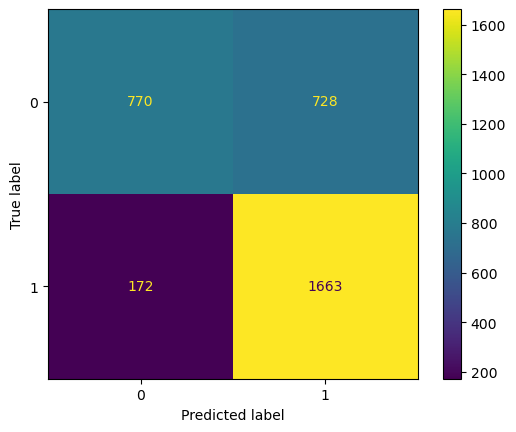

In [11]:
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test_label, y_pred=test_pred_gnb)
plt.show() 

**Compute ROC curve**

ROC curve plots TP (on the y-axis) against FP (on the x-axis)

Meaning for (TP, FP) coordinates:
* (0,0): declare everything to be negative class
* (1,1): declare everything to be positive class
* (0,1): ideal

Diagonal line corresponds to random guessing

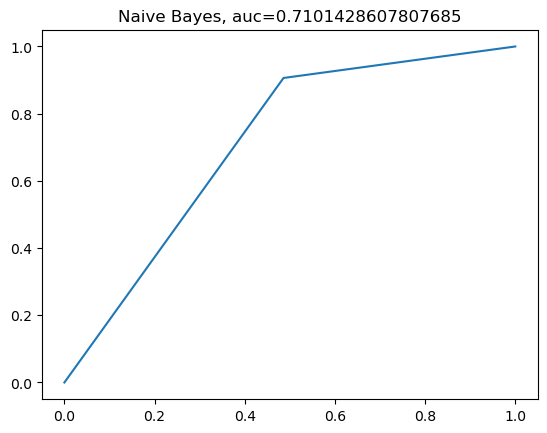

In [12]:
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)

plt.title(f"Naive Bayes, auc={auc}")
plt.plot(
    fpr,
    tpr
)

## Putting all together

Gaussian Non scaled data
Accuracy train set  0.7380401234567902
Accuracy test set  0.72997299729973
Precision train set  0.7577647949258706
Recall train set  0.7380401234567902
F1 score train set  0.7261543370904787
Support train set  (array([0.82515611, 0.70274666]), array([0.52932761, 0.90843261]), array([0.64493638, 0.79246052]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.82      0.51      0.63      1498
        Bots       0.70      0.91      0.79      1835

    accuracy                           0.73      3333
   macro avg       0.76      0.71      0.71      3333
weighted avg       0.75      0.73      0.72      3333



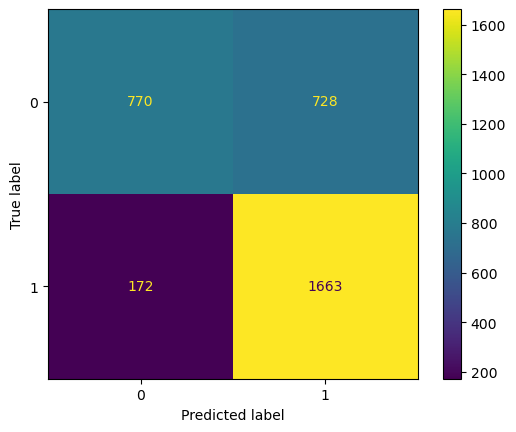

Gaussian Scaled data
Accuracy train set  0.6619084362139918
Accuracy test set  0.663066306630663
Precision train set  0.7710679396943311
Recall train set  0.6619084362139918
F1 score train set  0.6039510492076641
Support train set  (array([0.95483193, 0.62104338]), array([0.26008584, 0.98995562]), array([0.40881493, 0.76325979]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.94      0.27      0.42      1498
        Bots       0.62      0.99      0.76      1835

    accuracy                           0.66      3333
   macro avg       0.78      0.63      0.59      3333
weighted avg       0.76      0.66      0.61      3333



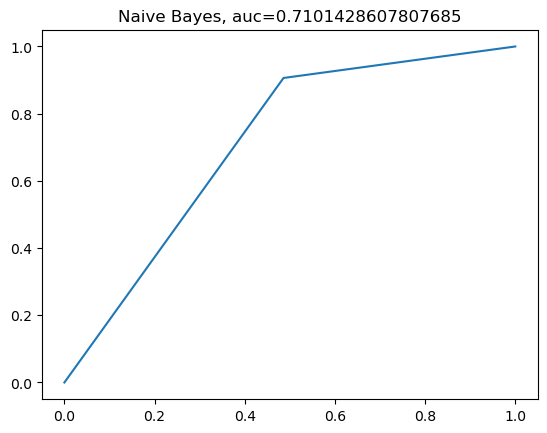

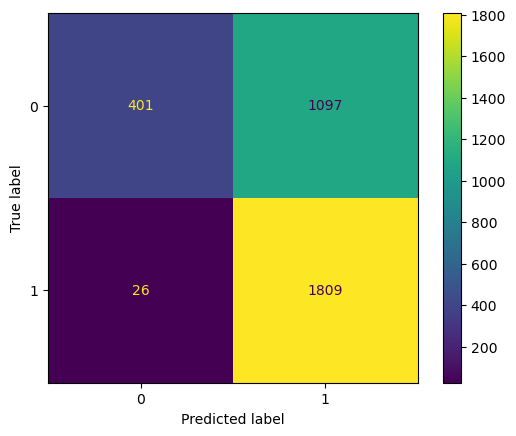




Bernoulli Non scaled data
Accuracy train set  0.6765689300411523
Accuracy test set  0.6720672067206721
Precision train set  0.7017796476871203
Recall train set  0.6765689300411523
F1 score train set  0.6745093270509122
Support train set  (array([0.60601471, 0.77996195]), array([0.80143062, 0.5746321 ]), array([0.69015646, 0.66173504]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.60      0.79      0.69      1498
        Bots       0.77      0.57      0.66      1835

    accuracy                           0.67      3333
   macro avg       0.69      0.68      0.67      3333
weighted avg       0.70      0.67      0.67      3333



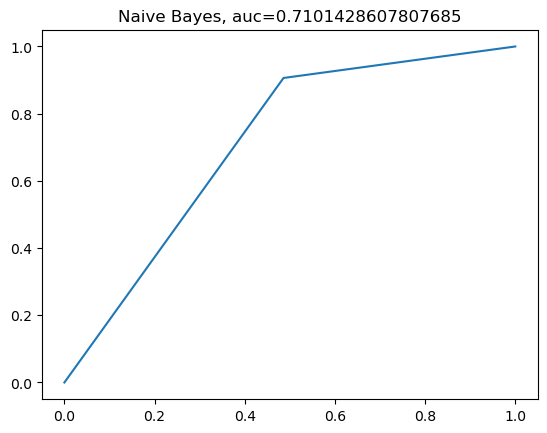

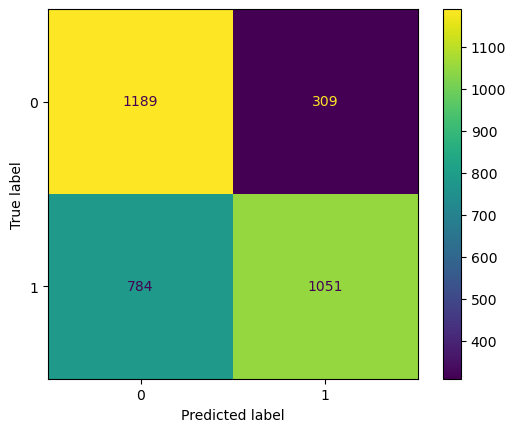

Bernoulli Scaled data
Accuracy train set  0.6741255144032922
Accuracy test set  0.6708670867086709
Precision train set  0.7000862595036815
Recall train set  0.6741255144032922
F1 score train set  0.671864570604227
Support train set  (array([0.60344456, 0.77898435]), array([0.80200286, 0.5697267 ]), array([0.68869779, 0.65812196]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.60      0.80      0.69      1498
        Bots       0.77      0.57      0.66      1835

    accuracy                           0.67      3333
   macro avg       0.69      0.68      0.67      3333
weighted avg       0.70      0.67      0.67      3333



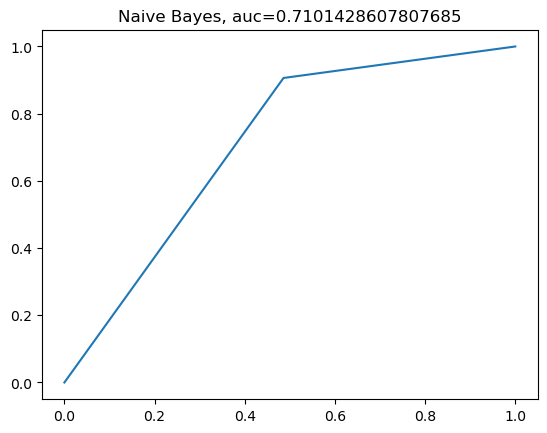

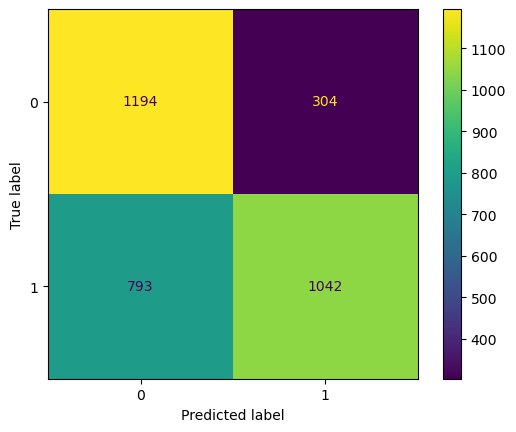




Complement Non scaled data
Accuracy train set  0.7879372427983539
Accuracy test set  0.783978397839784
Precision train set  0.8150247135179627
Recall train set  0.7879372427983539
F1 score train set  0.778523683678753
Support train set  (array([0.90876882, 0.73849221]), array([0.58712446, 0.9518804 ]), array([0.71336694, 0.83171752]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.91      0.57      0.71      1498
        Bots       0.73      0.95      0.83      1835

    accuracy                           0.78      3333
   macro avg       0.82      0.76      0.77      3333
weighted avg       0.81      0.78      0.77      3333



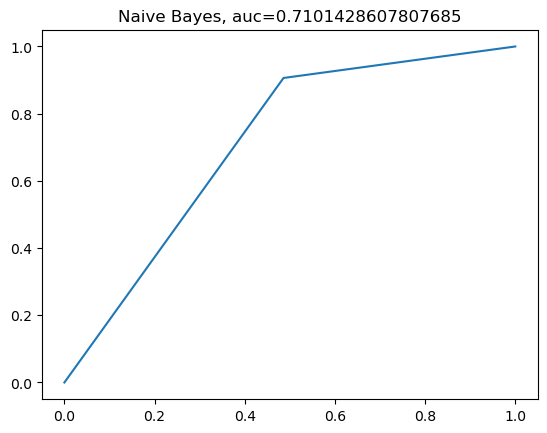

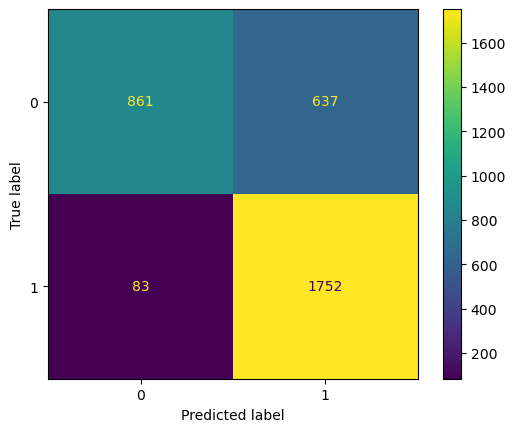

Complement Scaled data
Accuracy train set  0.8311471193415638
Accuracy test set  0.8238823882388239
Precision train set  0.8440415132546929
Recall train set  0.8311471193415638
F1 score train set  0.8271956312234429
Support train set  (array([0.91015038, 0.79007037]), array([0.69270386, 0.94417192]), array([0.7866775 , 0.86027456]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.92      0.67      0.77      1498
        Bots       0.78      0.95      0.86      1835

    accuracy                           0.82      3333
   macro avg       0.85      0.81      0.81      3333
weighted avg       0.84      0.82      0.82      3333



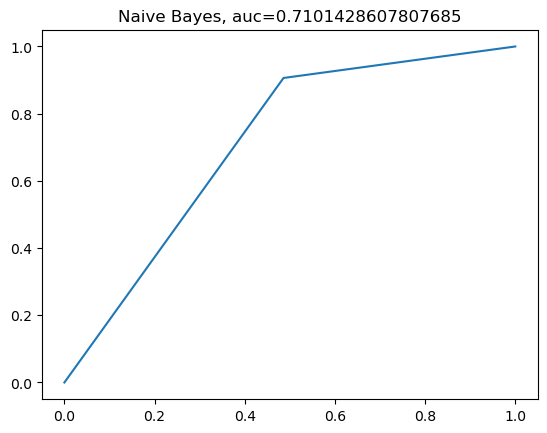

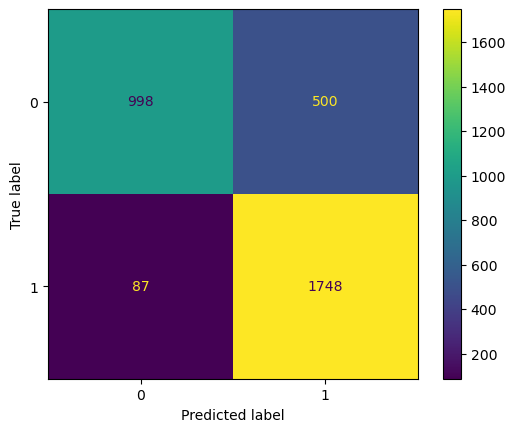




Multinomial Non scaled data
Accuracy train set  0.7879372427983539
Accuracy test set  0.783978397839784
Precision train set  0.8150247135179627
Recall train set  0.7879372427983539
F1 score train set  0.778523683678753
Support train set  (array([0.90876882, 0.73849221]), array([0.58712446, 0.9518804 ]), array([0.71336694, 0.83171752]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.91      0.57      0.71      1498
        Bots       0.73      0.95      0.83      1835

    accuracy                           0.78      3333
   macro avg       0.82      0.76      0.77      3333
weighted avg       0.81      0.78      0.77      3333



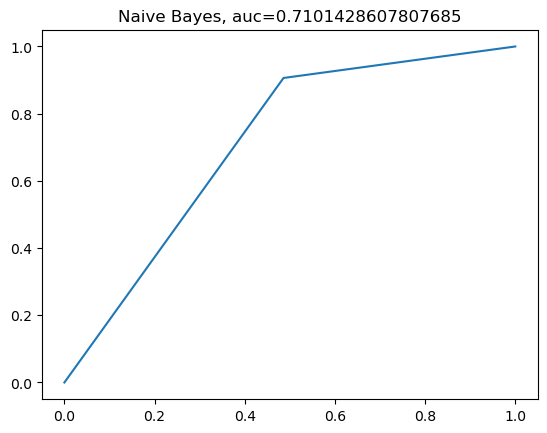

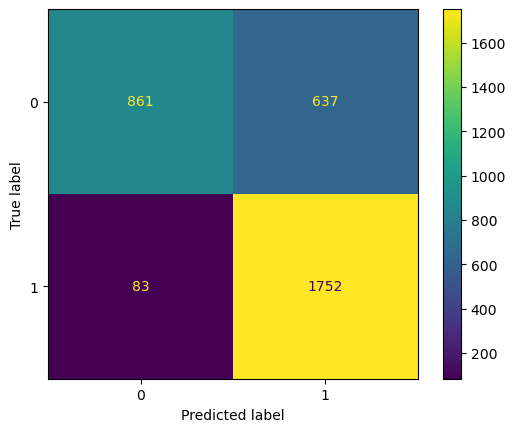

Multinomial Scaled data
Accuracy train set  0.8258744855967078
Accuracy test set  0.8118811881188119
Precision train set  0.8488767250667697
Recall train set  0.8258744855967078
F1 score train set  0.8198287561966189
Support train set  (array([0.94107952, 0.77360254]), array([0.65350501, 0.96659659]), array([0.77136103, 0.85939772]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.95      0.61      0.75      1498
        Bots       0.76      0.97      0.85      1835

    accuracy                           0.81      3333
   macro avg       0.85      0.79      0.80      3333
weighted avg       0.84      0.81      0.80      3333



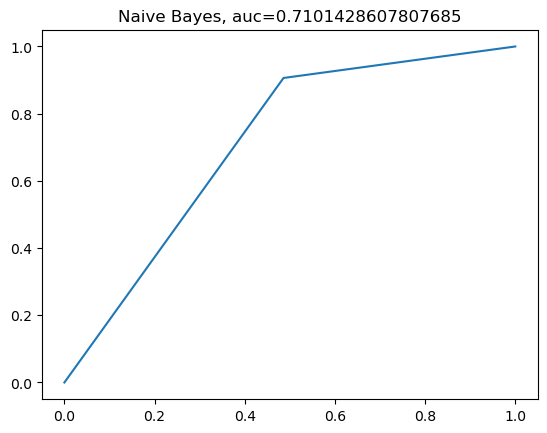

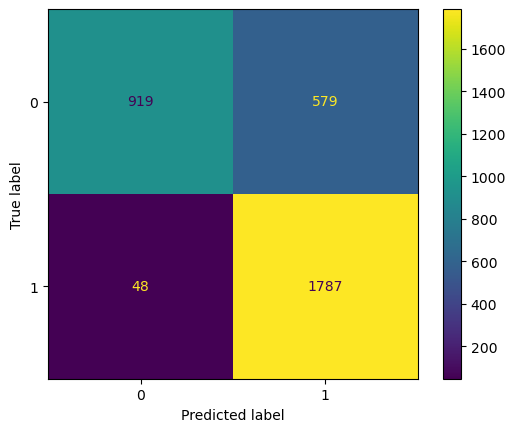

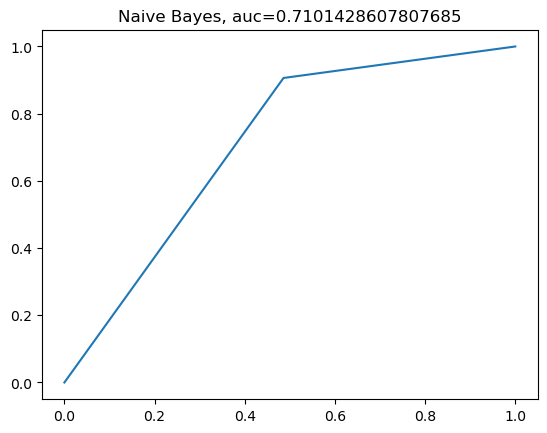

In [13]:
def process_model(nb, train_set, test_set, train_label, test_label):
    nb.fit(train_set, train_label) # fit the model
    train_pred_nb = nb.predict(train_set) # predict on train set 
    test_pred_nb = nb.predict(test_set) # predict on test set
    # print scores
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_nb))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_nb))
    print('Precision train set ', metrics.precision_score(train_label, train_pred_nb, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred_nb, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred_nb, average='weighted'))
    print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_nb))
    report_scores(test_label, test_pred_nb)
    # print confusion matrix
    metrics.ConfusionMatrixDisplay.from_predictions(y_true=test_label, y_pred=test_pred_nb)
    plt.show() 
    # print auc curve
    fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
    auc = metrics.roc_auc_score(test_label, test_pred_gnb)
    plt.title(f"Naive Bayes, auc={auc}")
    plt.plot(fpr, tpr)
    
def get_scaled_data(Scaler, train_set, test_set, columns):
    """
    Given a scaler and the training/test set, returns the scaled datasets in pandas
    dataframes
    """
    scaled_train_set = Scaler.fit_transform(train_set.values)
    scaled_test_set = Scaler.fit_transform(test_set.values)
    train_set = pd.DataFrame(data=scaled_train_set, columns=columns)
    test_set = pd.DataFrame(data=scaled_test_set, columns=columns)
    return train_set, test_set

models = [
    ("Gaussian", GaussianNB()),
    ("Complement", ComplementNB()),
    ("Multinomial", MultinomialNB())
]

scaled_train_set, scaled_test_set = get_scaled_data(MinMaxScaler(), train_set, test_set, df.columns)
for model_name, nb in models:
    print(f"{model_name} Non scaled data")
    process_model(nb, train_set, test_set, train_label, test_label)
    print(f"{model_name } Scaled data")
    process_model(nb, scaled_train_set, scaled_test_set, train_label, test_label)
    print("\n\n")

## Ensemble of all previously seen classifiers

### Non scaled data

Accuracy train set  0.800025720164609
Accuracy test set  0.7935793579357936
Precision train set  0.8217383793858098
Recall train set  0.800025720164609
F1 score train set  0.7926807546252066
Support train set  (array([0.90585774, 0.7530635 ]), array([0.61945637, 0.94744219]), array([0.7357689 , 0.83914348]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.91      0.60      0.72      1498
        Bots       0.74      0.95      0.84      1835

    accuracy                           0.79      3333
   macro avg       0.83      0.78      0.78      3333
weighted avg       0.82      0.79      0.78      3333



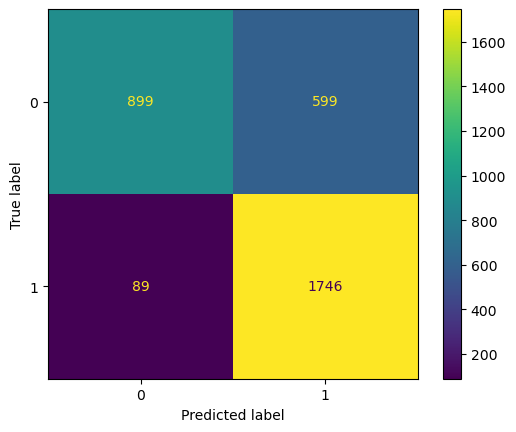

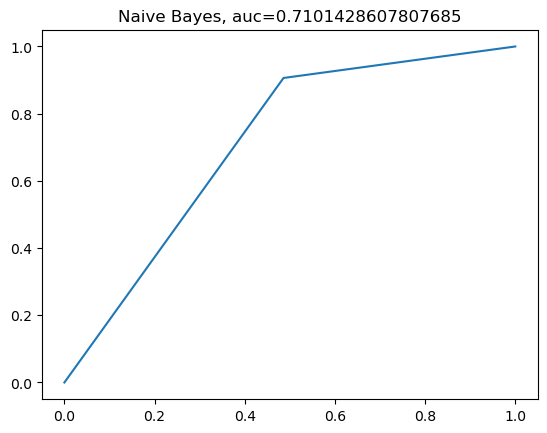

In [14]:
eclf = VotingClassifier(
    estimators=models,
    voting='hard'
)

process_model(eclf, train_set, test_set, train_label, test_label)

### Scaled Data

Accuracy train set  0.8364197530864198
Accuracy test set  0.8301830183018302
Precision train set  0.8541736364523947
Recall train set  0.8364197530864198
F1 score train set  0.8318030802015035
Support train set  (array([0.93502935, 0.78816319]), array([0.68354793, 0.96122401]), array([0.78975207, 0.86613345]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.95      0.66      0.78      1498
        Bots       0.78      0.97      0.86      1835

    accuracy                           0.83      3333
   macro avg       0.86      0.81      0.82      3333
weighted avg       0.85      0.83      0.82      3333



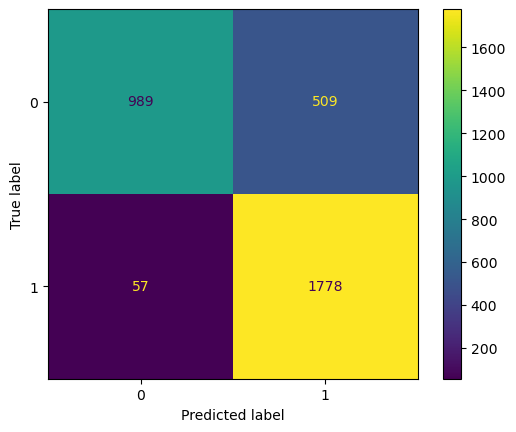

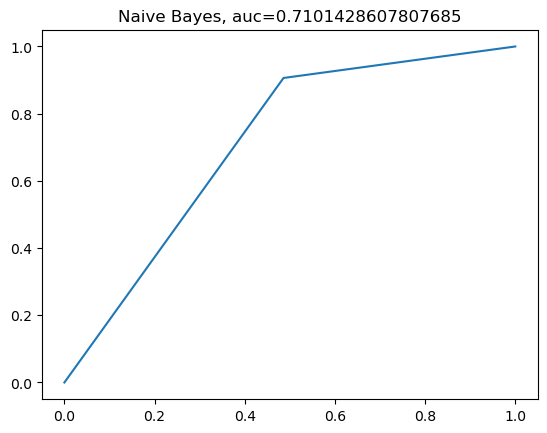

In [15]:
eclf = VotingClassifier(
    estimators=models,
    voting='hard'
)

process_model(eclf, scaled_train_set, scaled_test_set, train_label, test_label)